In [145]:
import seisbench
import seisbench.models as sbm
import seisbench.data as sbd
import seisbench.generate as sbg

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader


In [146]:

pn_model = sbm.PhaseNet.from_pretrained("stead")

In [147]:
seisbench.use_backup_repository()
eq_model = sbm.EQTransformer.from_pretrained("stead")

2024-09-09 12:06:21,976 | seisbench | WARNING | Setting remote root to: https://seisbench.gfz-potsdam.de/mirror/
Please note that this can affect your download speed.


In [148]:
data = sbd.TXED(cache="full",sampling_rate=100) #Esta accion es recomendable hacerla en terminal pues tarda mucho
                                #cambiar a "full" una vez que este completo el codigo
#data = sbd.DummyDataset(sampling_rate=50)  #sampling_rate=100
data.preload_waveforms(pbar=True) #importante, pbar==progressbar
print(data)

2024-09-09 12:06:22,973 | seisbench | WARNING | Output component order not specified, defaulting to 'ZNE'.
Preloading waveforms:   0%|          | 0/1046 [00:00<?, ?it/s]

Preloading waveforms: 100%|██████████| 1046/1046 [00:34<00:00, 30.04it/s]

TXED - 1046 traces


In [47]:
data.shape

(1046, 3, 6000)

In [149]:
batch_size=128
data_generator = sbg.GenericGenerator(data)
data_generator.augmentation(sbg.Normalize(detrend_axis=-1, amp_norm_axis=-1))

data_loader = DataLoader(data_generator, batch_size=batch_size, shuffle=False)

In [183]:
pn_model.eval()
P_pn = []
S_pn = []
for batch_id, batch in enumerate(data_loader):
    output = pn_model(batch['X'].float())
    for stream in output:
        P_pn.append(torch.argmax(stream[0]).item())
        S_pn.append(torch.argmax(stream[1]).item())


In [166]:
len(P_pn)

1046

3


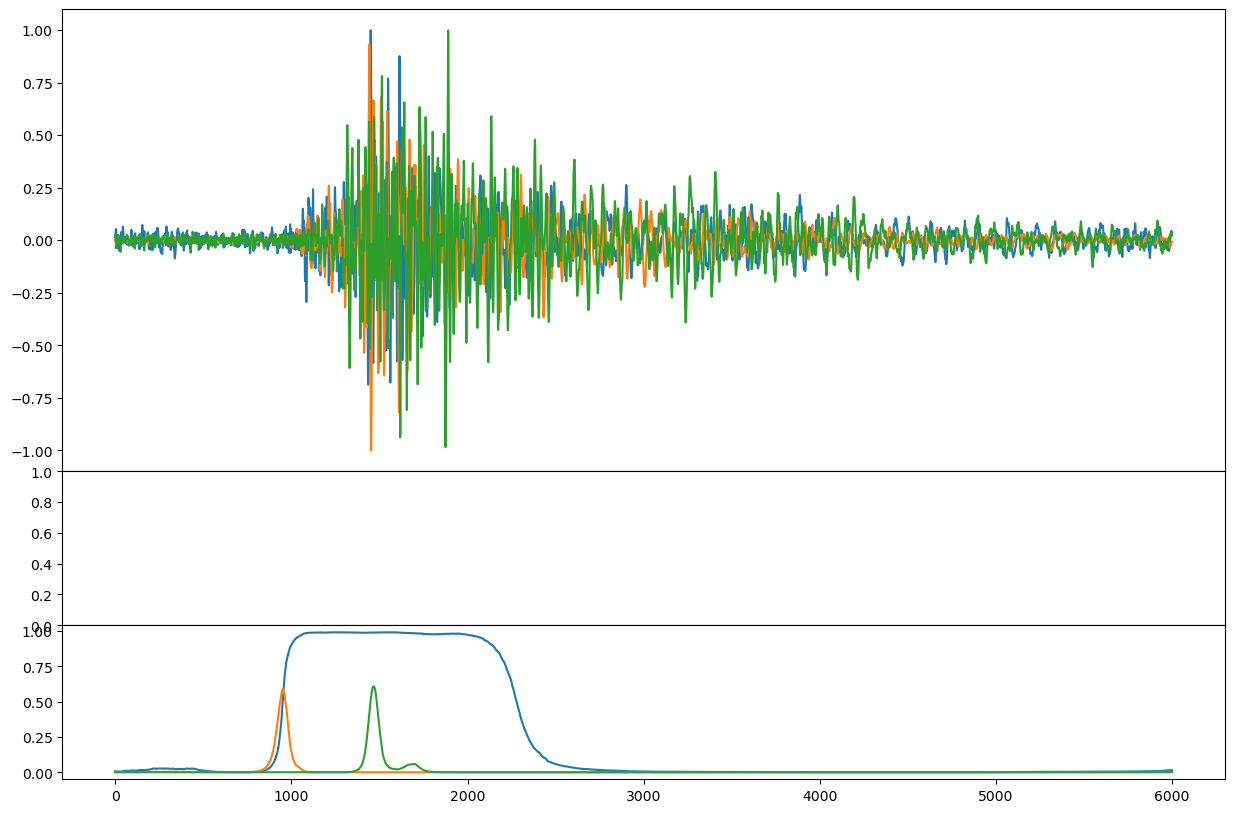

In [182]:
id= np.random.randint(22)
print(id)
sample = data_generator[id]

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(3, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [3, 1, 1]})
axs[0].plot(sample["X"].T)
#axs[1].plot(sample["y"].T)

pn_model.eval()  # close the model for evaluation
axs[2].plot(output[id].detach().numpy().T)


In [184]:
eq_model.eval()
P_eq = []
S_eq = []
for batch_id, batch in enumerate(data_loader):
    output = eq_model(batch['X'].float())
    output = torch.stack(output, dim=1)
    
    for stream in output:
        P_eq.append(torch.argmax(stream[1]).item())
        S_eq.append(torch.argmax(stream[0]).item())

In [185]:
len(P_eq)

1046

13


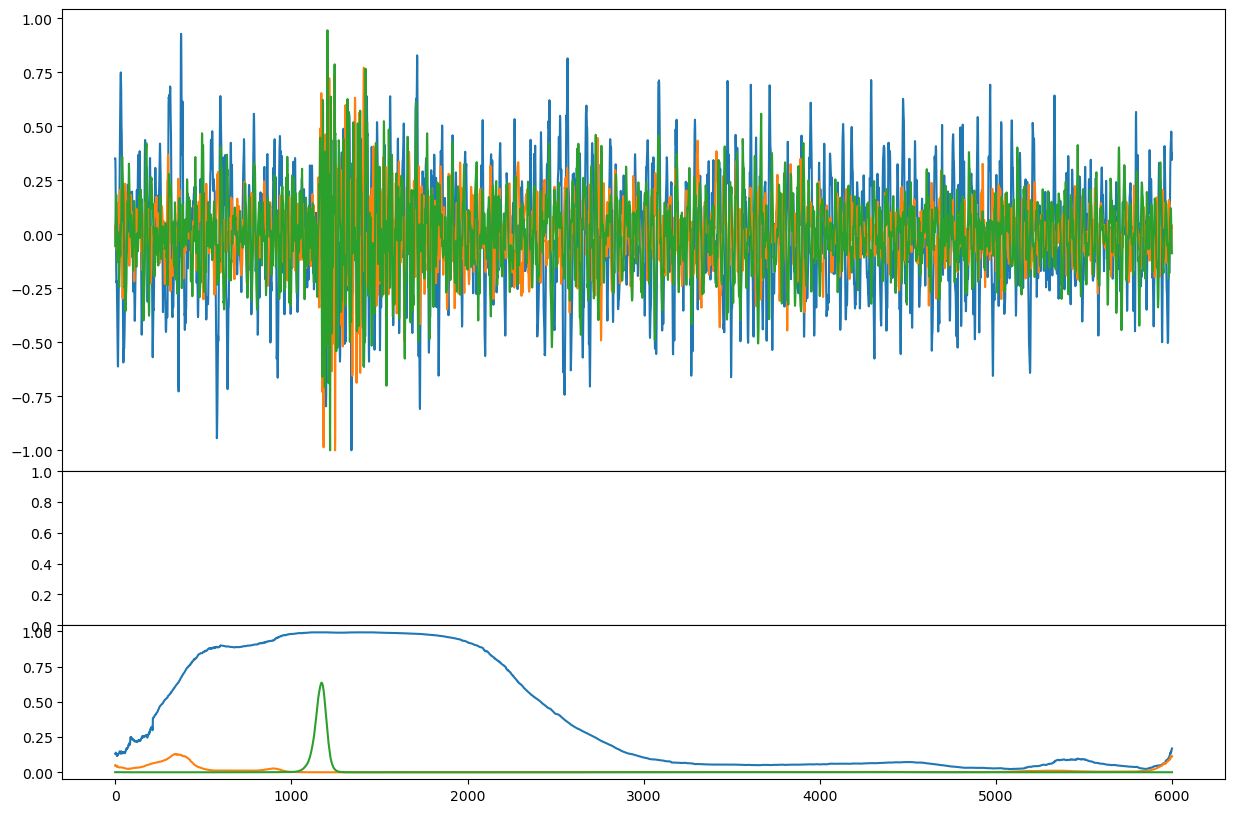

In [187]:
id= np.random.randint(22)
print(id)
sample = data_generator[id]

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(3, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [3, 1, 1]})
axs[0].plot(sample["X"].T)
#axs[1].plot(sample["y"].T)

pn_model.eval()  # close the model for evaluation
axs[2].plot(output[id].detach().numpy().T)


In [188]:
#P_pn = P_pn.detach().numpy()
data.metadata['P_pn'] = list(P_pn)

#S_pn = S_pn.detach().numpy()
data.metadata['S_pn'] = list(S_pn)

#P_eq = P_eq.detach().numpy()
data.metadata['P_eq'] = list(P_eq)

#S_eq = S_eq.detach().numpy()
data.metadata['S_eq'] = list(S_eq)


data.metadata.head()

,index,trace_coda_end_sample,source_depth_km,source_latitude_deg,source_longitude_deg,source_magnitude,source_origin_time,trace_p_arrival_sample,trace_p_arrival_time,trace_p_arrival_uncertainty_s,...,trace_causal,trace_polarity,ID_poligono,trace_chunk,trace_sampling_rate_hz,trace_component_order,P_pn,S_pn,P_eq,S_eq
0,0,1530.0,5.643115,31.244769,-103.553538,1.413654,2019-04-02T03:34:48.725819Z,1034.0,2019-04-02T03:34:52.621560Z,0.2,...,unknown,unknown,2,,100,ZNE,1001,1189,1033,1142
1,1,646.0,3.072314,31.445149,-103.586818,1.343138,2019-04-02T15:44:47.758892Z,398.0,2019-04-02T15:44:49.774274Z,0.2,...,unknown,unknown,1,,100,ZNE,409,439,394,588
2,2,1357.0,6.157275,31.274182,-103.572833,1.532322,2019-04-03T00:19:32.460730Z,863.0,2019-04-03T00:19:35.861650Z,0.3,...,unknown,unknown,2,,100,ZNE,878,1019,861,1181
3,3,1602.0,5.540283,31.253961,-103.559968,2.021868,2019-04-03T02:49:31.391207Z,962.0,2019-04-03T02:49:34.487029Z,0.3,...,unknown,unknown,2,,100,ZNE,959,1296,1051,1242
4,4,959.0,6.131567,31.250054,-103.556485,1.866408,2019-04-03T04:07:27.403390Z,427.0,2019-04-03T04:07:31.281541Z,0.2,...,unknown,unknown,2,,100,ZNE,375,672,420,617


In [ ]:
#para guardar el archivo
data.metadata.to_csv("/Users/lamb/Documents/Modelo_Velocidades/metadata_Picks.csv",index=False)